# generation.cnn.vr_rest

> Fill in a module description here

In [ ]:
from monitosed.data.core import *
from monitosed.generation.core import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import mat73
from fastcore.xtras import Path
import pandas as pd
import numpy as np

from tsai.all import *

# Prepare Data

In [ ]:
path_rest = Path("../_data/foot1/Rest"); path_rest.ls()
path_vr = Path("../_data/foot1/VR"); path_vr.ls()

(#15) [Path('../_data/foot1/VR/VR20_VRstim_data_clean.mat'),Path('../_data/foot1/VR/VR23_VRStim_data_clean.mat'),Path('../_data/foot1/VR/VR31_VRstim_data_clean.mat'),Path('../_data/foot1/VR/VR26_VRStim_data_clean.mat'),Path('../_data/foot1/VR/VR27_VRstim_data_clean.mat'),Path('../_data/foot1/VR/VR34_VRstim_data_clean.mat'),Path('../_data/foot1/VR/VR41_VRStim_data_clean.mat'),Path('../_data/foot1/VR/VR51_VRStim_data_clean.mat'),Path('../_data/foot1/VR/VR35_VRStim_data_clean.mat'),Path('../_data/foot1/VR/VR40_VRstim_data_clean.mat')...]

## Load data

In [ ]:
from tqdm.notebook import tqdm
import mat73
import scipy

In [ ]:
def load_mats(path, max_len=None):
    mats = []
    length = ifnone(max_len, len(path.ls()))
    for mat in tqdm(sorted(path.ls())[:length]):
        try: 
            print(f"Loading: {mat.name}")
            mats.append(mat73.loadmat(mat))
        except:
            print(f"Loading: {mat.name}")
            mats.append(scipy.io.loadmat(mat))
    return mats

In [ ]:
mats_rest = load_mats(path_rest)
mats_vr = load_mats(path_vr)

  0%|          | 0/14 [00:00<?, ?it/s]

Loading: VR20_Reststim_data_clean.mat
Loading: VR23_RestStim_data_clean.mat
Loading: VR26_Reststim_data_clean.mat
Loading: VR27_Reststim_data_clean.mat
Loading: VR31_Reststim_data_clean.mat
Loading: VR35_RestStim_data_clean.mat
Loading: VR38_RestStim_data_clean.mat
Loading: VR40_RestStim_data_clean.mat
Loading: VR41_RestStim_data_clean.mat
Loading: VR51_RestStim_data_clean.mat
Loading: VR52_RestStim_data_clean.mat
Loading: VR57_Reststim_data_clean.mat
Loading: VR59_Reststim_data_clean.mat
Loading: VR60_Reststim_data_clean.mat


  0%|          | 0/14 [00:00<?, ?it/s]

Loading: VR20_VRstim_data_clean.mat
Loading: VR23_VRStim_data_clean.mat
Loading: VR26_VRStim_data_clean.mat
Loading: VR27_VRstim_data_clean.mat
Loading: VR31_VRstim_data_clean.mat
Loading: VR35_VRStim_data_clean.mat
Loading: VR38_VRStim_data_clean.mat
Loading: VR40_VRstim_data_clean.mat
Loading: VR41_VRStim_data_clean.mat
Loading: VR51_VRStim_data_clean.mat
Loading: VR52_VRStim_data_clean.mat
Loading: VR57_VRstim_data_clean.mat
Loading: VR59_VRstim_data_clean.mat
Loading: VR60_VRstim_data_clean.mat


In [ ]:
#Optional
signal_len = 1000

## Get labels

The first idea is to perform forecasting, i.e. predict the future signal. To do so, we have to cut the measured signal into a past and the future we would like to predict.

/!\ the stimulus happens at 250

In [ ]:
trn_len = 1000
pred_len = signal_len-trn_len

## DataBlock

In [ ]:
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
data = np.concatenate([read_data(mat) for mat in mats_rest])
data = data[:,:,:signal_len]
data.shape

(778, 173, 1000)

In [ ]:
data = np.stack([read_data(mat).mean(0) for mat in mats_rest])
data = data[:,:signal_len]
data.shape

(14, 173, 1500)

[<matplotlib.lines.Line2D>]

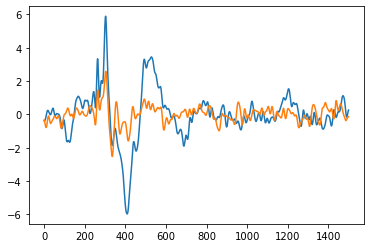

In [ ]:
plt.plot(data[2][0])
plt.plot(labels[2][0])

In [ ]:
labels = np.concatenate([read_data(mat) for mat in mats_vr])
labels = labels[:,:,:signal_len]
labels.shape

(795, 173, 1000)

In [ ]:
labels = np.stack([read_data(mat).mean(0) for mat in mats_vr])
labels = labels[:,:signal_len]
labels.shape

(14, 173, 1500)

In [ ]:
read_data(mats_rest[0]).shape

(57, 173, 1500)

In [ ]:
x = torch.from_numpy(np.concatenate(data, axis=0)).unsqueeze(1)
y = torch.from_numpy(np.concatenate(labels, axis=0)).unsqueeze(1)
x.shape, y.shape

(torch.Size([2422, 1, 1500]), torch.Size([2422, 1, 1500]))

In [ ]:
train_ix = int((1-valid_pct)*len(mats))
read_mats = [read_data(mat) for mat in mats]
rearranged_mats = [new_rearrange(mat) for mat in read_mats]
n_train_sample = np.concatenate(rearranged_mats[:train_ix]).shape[0]
return (np.arange(0, n_train_sample), np.arange(n_train_sample, np.concatenate(rearranged_mats).shape[0]))

In [ ]:
splits = create_splits(mats_rest)

In [ ]:
splits = (np.arange(0, 11), np.arange(11, 14))

In [ ]:
splits

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([11, 12, 13]))

In [ ]:
dls = get_ts_dls(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), splits=splits, bs=128)

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([11, 1, 1500]), torch.Size([11, 1, 1500]))

[<matplotlib.lines.Line2D>]

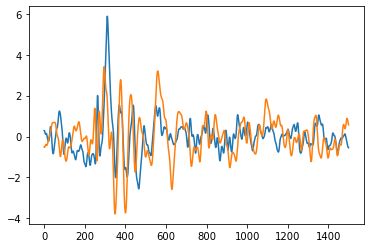

In [ ]:
plt.plot(xb[0][0].to('cpu').numpy())
plt.plot(yb[0][0].to('cpu').numpy())

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, size_average=None, reduce=None, alpha=0.5, reduction: str = 'mean') -> None:
        super(CustomLoss, self).__init__()
        store_attr()

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        l1 = F.l1_loss(input, target, reduction=self.reduction)
        mse = F.mse_loss(input, target, reduction=self.reduction)
        return self.alpha*l1 + (1-self.alpha)*mse

In [ ]:
yb.shape

torch.Size([11, 1, 1500])

In [ ]:
model = TimeSeriesModel(1, yb.shape[2])
learn = Learner(dls, model, loss_func=CustomLoss(), metrics=[mae, rmse], wd=10, cbs=ShowGraph())

SuggestedLRs(valley=9.120108734350652e-05)

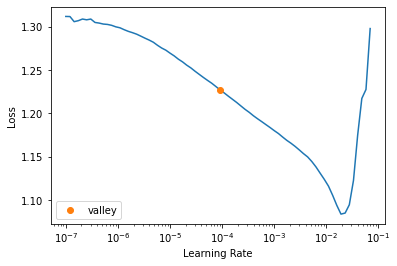

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.299301,1.017650,0.723258,1.145495,00:00
1,1.258223,1.015414,0.721979,1.144166,00:00
2,1.226679,1.014164,0.721362,1.143299,00:00
3,1.201110,1.014524,0.721896,1.143373,00:00
4,1.179566,1.013083,0.721242,1.142406,00:00
5,1.160073,1.007014,0.717782,1.138561,00:00
6,1.148064,1.002438,0.715046,1.135702,00:00
7,1.139866,0.995614,0.711092,1.131462,00:00
8,1.131695,0.993450,0.710330,1.129906,00:00
9,1.123435,0.996208,0.713233,1.130965,00:00


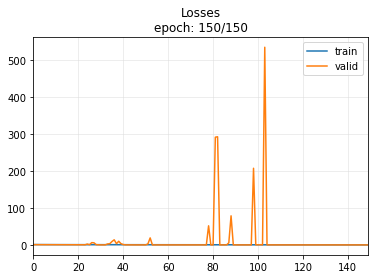

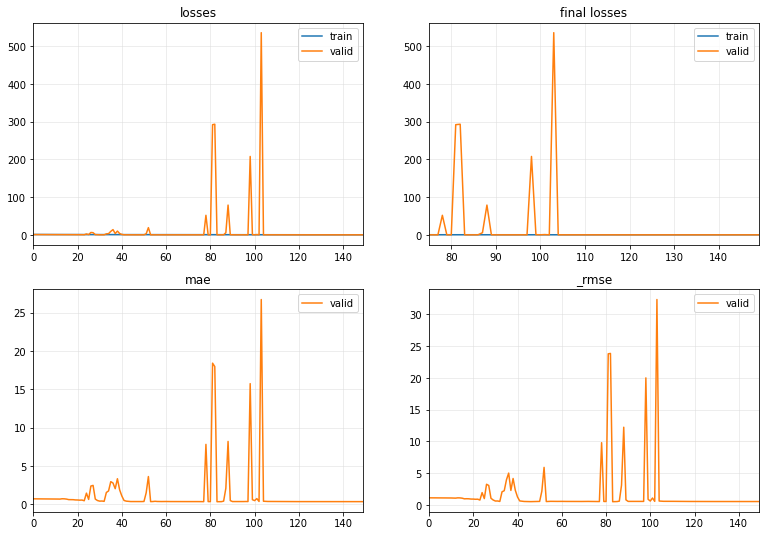

In [ ]:
learn.fit_one_cycle(150, lr_max=1e-2)

In [ ]:
in_valid, pred_valid, true_valid = learn.get_preds(with_input=True)

[<matplotlib.lines.Line2D>]

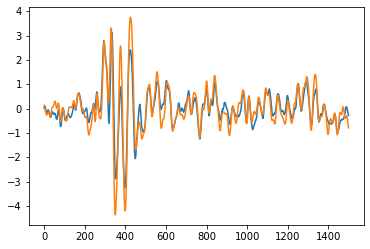

In [ ]:
#plt.plot(in_valid[2][0].to('cpu').numpy())
plt.plot(pred_valid[].to('cpu').numpy())
plt.plot(true_valid[2][0].to('cpu').numpy())

In [ ]:
inf = read_data(mats_rest[0])

In [ ]:
in_valid.shape

torch.Size([3, 1, 1500])

In [ ]:
inf[1][0].max()

29.977590216479552

In [ ]:
torch.tensor(inf[0][0], dtype=torch.float32).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1500])

In [ ]:
torch.tensor(inf[0][0], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')

tensor([[[ 0.4247,  0.9331,  1.5741,  ..., -0.8875, -2.1496, -3.0908]]],
       device='cuda:0')

In [ ]:
test_probas, test_targets, test_preds = learn.get_X_preds(torch.tensor(inf[1][0], dtype=torch.float32).unsqueeze(0).unsqueeze(0), with_decoded=True)

[<matplotlib.lines.Line2D>]

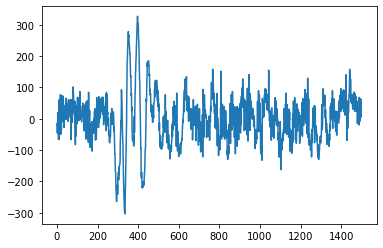

In [ ]:
plt.plot(test_preds[0])

In [ ]:
learn.model(torch.tensor(inf[0][0], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0'))

tensor([[-26.7151,  18.9569, -21.5338,  ...,  42.8832,   9.8944,  10.3061]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

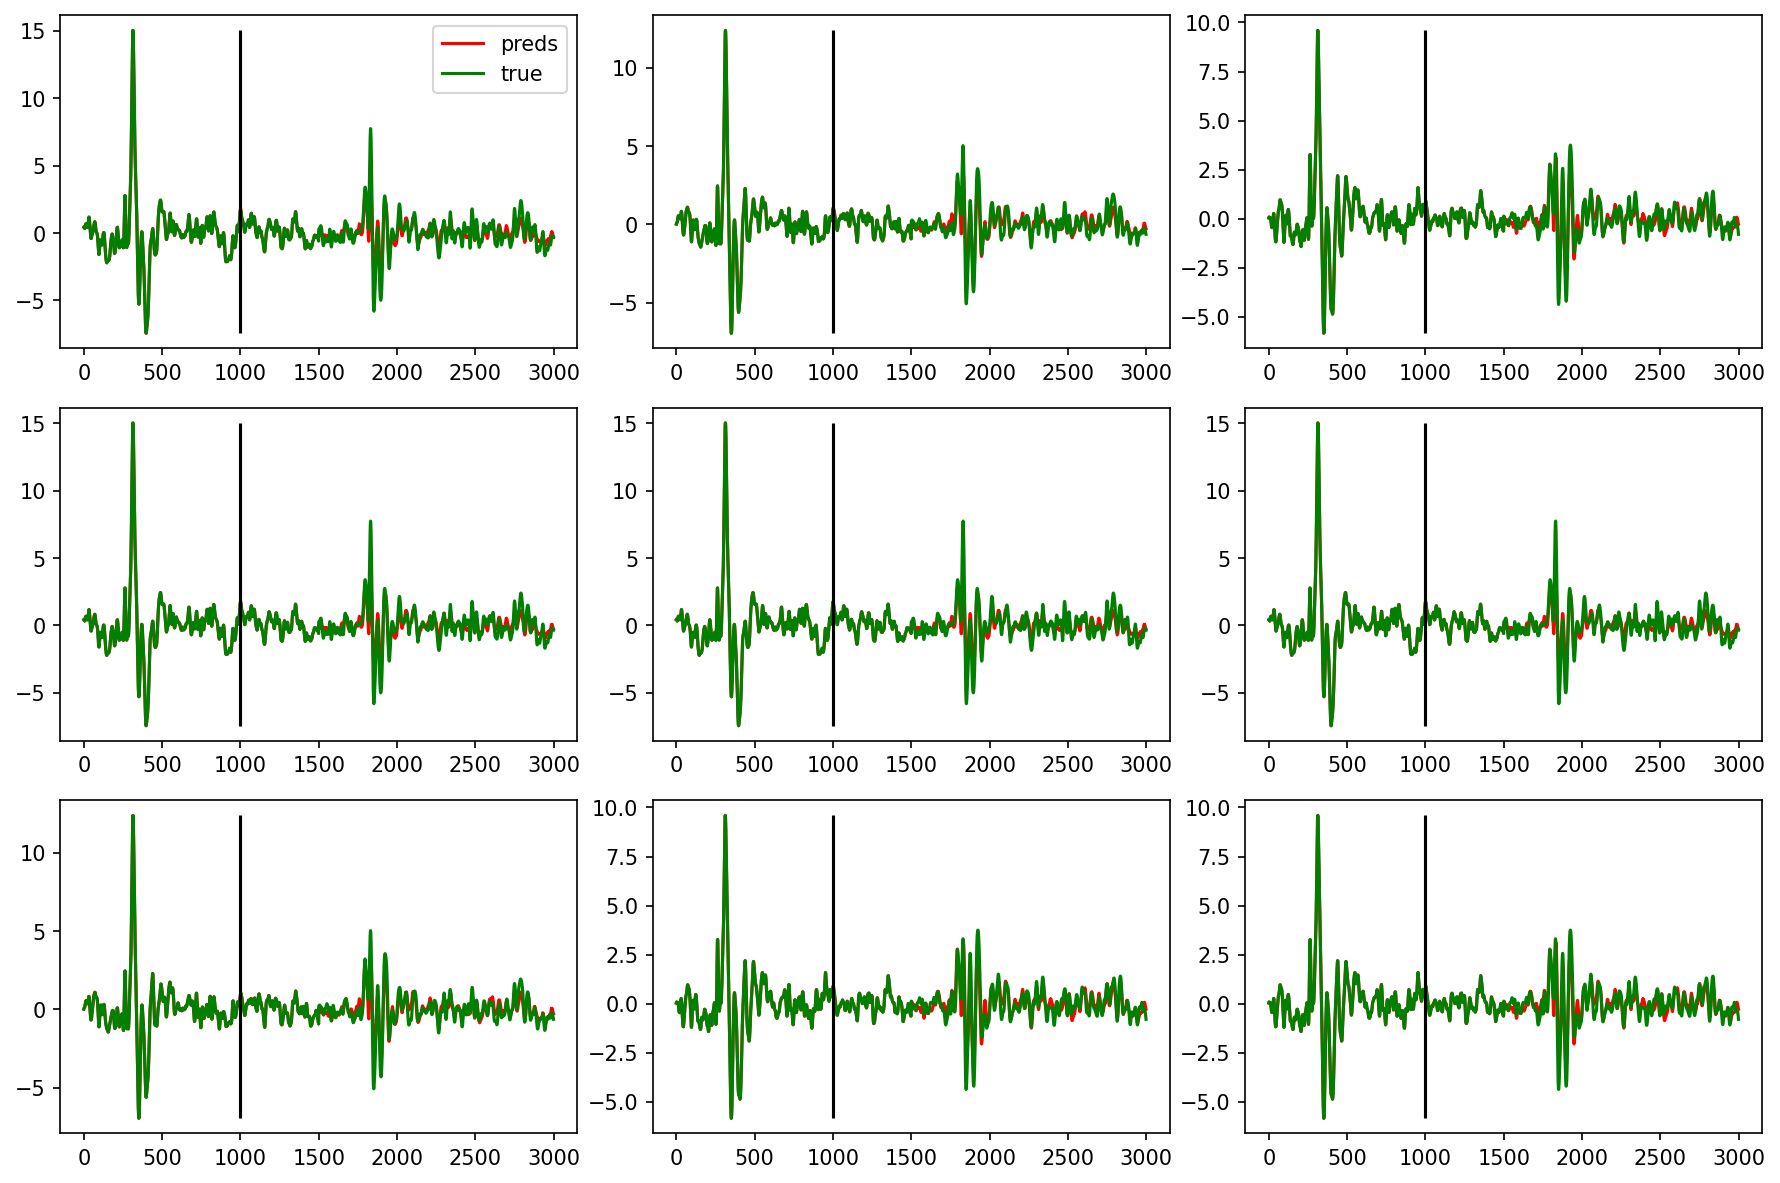

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,8), dpi=150)
for i, ax in enumerate(axes.flat):
    plot_idx = np.random.choice(np.arange(0, len(in_valid)))
    true = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), true_valid.numpy()[plot_idx,:].reshape(-1)])
    pred = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), pred_valid[plot_idx,:].reshape(-1)])
    ax.plot(pred, color='red', label='preds')
    ax.plot(true, color='green', label='true')
    ax.vlines(trn_len-1, np.min(true), np.max(true), color='black')
    if i == 0: ax.legend()
fig.tight_layout();